Cryptocurrency trading bot.

In [1]:
##%pip install python-binance==0.7.5
#%pip install python-binance

## Global constants.

In [2]:
symbol = 'OCEANUSDT'
interval = '1h'
period = 100

## API key management.

In [3]:
from cryptocurrency.authentication import Cryptocurrency_authenticator
authenticator = Cryptocurrency_authenticator(use_keys=False, testnet=False)
client = authenticator.spot_client
client

## Get all available pairs for information needed to trade.

In [4]:
from cryptocurrency.exchange import Cryptocurrency_exchange
exchange = Cryptocurrency_exchange(client=client, directory='crypto_logs')
exchange_info = exchange.info
exchange_info

,symbol,base_asset,base_asset_precision,quote_asset,quote_precision,quote_asset_precision,base_asset_commission,quote_commission_precision,allow_trailing_stop,cancel_replace_allowed,min_price,max_price,tick_size,step_size,multiplier_up,multiplier_down
0,ETHBTC,ETH,8,BTC,8,8,8,8,True,True,1.000000e-06,922327.0,1.000000e-06,0.0001,5.0,0.2
1,LTCBTC,LTC,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0010,5.0,0.2
2,BNBBTC,BNB,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0010,5.0,0.2
3,NEOBTC,NEO,8,BTC,8,8,8,8,True,True,1.000000e-06,100000.0,1.000000e-06,0.0100,5.0,0.2
4,QTUMETH,QTUM,8,ETH,8,8,8,8,True,True,1.000000e-06,1000.0,1.000000e-06,0.1000,5.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,VITEBUSD,VITE,8,BUSD,8,8,8,8,True,True,1.000000e-05,1000.0,1.000000e-05,0.1000,5.0,0.2
1411,HOOKBTC,HOOK,8,BTC,8,8,8,8,True,True,1.000000e-08,1.0,1.000000e-08,0.1000,5.0,0.2
1412,HOOKUSDT,HOOK,8,USDT,8,8,8,8,True,True,1.000000e-04,1000.0,1.000000e-04,0.1000,5.0,0.2
1413,HOOKBUSD,HOOK,8,BUSD,8,8,8,8,True,True,1.000000e-04,1000.0,1.000000e-04,0.1000,5.0,0.2


## Get conversion table for price conversions.

In [5]:
from cryptocurrency.conversion_table import get_conversion_table

conversion_table = get_conversion_table(client=client, exchange_info=exchange_info, 
                                        offset_s=0, as_pair=True, dump_raw=False, 
                                        minimal=True, extra_minimal=False, 
                                        convert_to_USDT=False)
conversion_table

,symbol,price_change,price_change_percent,weighted_average_price,close_shifted,close,last_volume,bid_price,bid_volume,ask_price,...,rolling_quote_volume,open_time,first_ID,last_ID,count,base_asset,quote_asset,rolling_base_quote_volume,bid_ask_percent_change,bid_ask_volume_percent_change
close_time,,,,,,,,,,,,,,,,,,,,,
2022-12-04 13:40:22.387,USDTIDRT,-42.00,-0.270,15541.99,15621.000000,15532.000000,12.00000000,15532.000000,234.00,15543.000000,...,1.881824e+09,1670092822387,2755996,2756426,431,USDT,IDRT,1.211578e+05,0.070771,28.996283
2022-12-04 13:58:22.253,C98BNB,-0.00000700,-0.832,0.00083555,0.000841,0.000834,1050.00000000,0.000829,208.10,0.000834,...,4.641242e+02,1670093902253,1348590,1349046,457,C98,BNB,5.565038e+05,0.599520,7.419953
2022-12-04 14:02:15.088,SCETH,-0.00000003,-1.435,0.00000208,0.000002,0.000002,7506.00000000,0.000002,47460.00,0.000002,...,8.983633e+00,1670094135088,3138059,3138201,143,SC,ETH,4.360987e+06,0.966184,86.372570
2022-12-04 14:02:21.090,JOEBTC,-0.00000019,-1.707,0.00001100,0.000011,0.000011,80.31000000,0.000011,1080.68,0.000011,...,1.664423e+00,1670094141090,760470,761010,541,JOE,BTC,1.521410e+05,0.548446,99.156780
2022-12-04 14:02:33.386,BUSDVAI,0.00800000,0.776,1.03112285,1.036000,1.039000,93.90000000,1.034000,32.00,1.038000,...,6.892541e+03,1670094153386,602465,602470,6,BUSD,VAI,6.633822e+03,0.385356,19.753086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04 14:16:14.162,XRPUSDT,-0.00280000,-0.711,0.38972608,0.393700,0.391000,29124.00000000,0.391000,91270.00,0.391100,...,5.077997e+07,1670094974162,491990544,492071615,81072,XRP,USDT,1.298720e+08,0.025569,51.701967
2022-12-04 14:16:14.166,OPUSDT,0.00300000,0.286,1.04113233,1.050000,1.052000,362.95000000,1.052000,14203.01,1.053000,...,1.413086e+07,1670094974166,16043163,16078081,34919,OP,USDT,1.343238e+07,0.094967,83.406749
2022-12-04 14:16:14.167,FILUSDT,0.05000000,1.109,4.47722869,4.520000,4.560000,2065.99000000,4.550000,34646.20,4.560000,...,8.248755e+06,1670094974167,151968987,151985736,16750,FIL,USDT,1.808938e+06,0.219298,78.564914


## Pre-screen buyable base assets in pairs.

In [6]:
from cryptocurrency.conversion_table import get_new_filtered_tickers

tickers_list = get_new_filtered_tickers(conversion_table=conversion_table, as_pair=True)
len(tickers_list)

1338

## Order book.

In [7]:
from time import sleep
import pandas as pd

def get_order_book_depth(symbol):
    sleep(2.9)
    depth = client.get_order_book(symbol=symbol, limit=5000)
    frames = {side: pd.DataFrame(data=depth[side], columns=['price', 'quantity'], dtype=float) 
              for side in ['bids', 'asks']}
    frames_list = [frames[side].assign(side=side) for side in frames]
    data = pd.concat(frames_list, axis='index', ignore_index=True, sort=True)
    return data

def get_bid_ask_range(symbol):
    data = get_order_book_depth(symbol=symbol)
    min_prices = data.groupby('side').price.min()
    max_prices = data.groupby('side').price.max()
    center_price = ((min_prices.loc['asks'] - max_prices.loc['bids']) + max_prices.loc['bids'])
    bid_range = (((center_price - min_prices.loc['bids']) / min_prices.loc['bids']) * 100)
    ask_range = (((max_prices.loc['asks'] - center_price) / center_price) * 100)
    return bid_range, ask_range

def get_upper_range_bigger_than_threshold_percent(symbol, threshold=100):
    bid_range, ask_range = get_bid_ask_range(symbol)
    trigger = ask_range > threshold
    return trigger

def get_lower_range_bigger_than_threshold_percent(symbol, threshold=100):
    bid_range, ask_range = get_bid_ask_range(symbol)
    trigger = bid_range > threshold
    return trigger

get_upper_range_bigger_than_threshold_percent(symbol='USTCBUSD', threshold=100)

False

In [8]:
#from tqdm import tqdm
#
#while True:
#    tickers_list = get_new_tickers(client=client, conversion_table=conversion_table)
#    sleep(5)
#    interesting_pairs = [symbol for symbol in tqdm(tickers_list) 
#                         if get_upper_range_bigger_than_threshold_percent(symbol=symbol, threshold=10000)]
#    if len(interesting_pairs) > 0:
#        print(interesting_pairs)

In [9]:
#tickers_list

In [10]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

symbol = 'USTCBUSD'
t1 = time()
depth = client.get_order_book(symbol=symbol, limit=5000)
t2 = time()
print('Elapsed time:', (t2 - t1), 'seconds')
frames = {side: pd.DataFrame(data=depth[side], columns=['price', 'quantity'], dtype=float) 
          for side in ['bids', 'asks']}
frames_list = [frames[side].assign(side=side) for side in frames]
data = pd.concat(frames_list, axis='index', ignore_index=True, sort=True)
t2 = time()
print('Elapsed time:', (t2 - t1), 'seconds')
max_quantities = data.groupby('side').quantity.max()
height_based_direction = ((max_quantities.loc['asks'] - max_quantities.loc['bids']) / max_quantities.loc['bids'])
height_based_direction *= 100
height_based_direction

Elapsed time: 0.18577313423156738 seconds
Elapsed time: 0.19552946090698242 seconds


-30.20817722298212

In [11]:
max_quantities.loc['bids'], max_quantities.loc['asks']

(4837657.0, 3376289.0)

In [12]:
data[data['side'] == 'bids'].shape[0], data[data['side'] == 'asks'].shape[0]

(2145, 5000)

In [13]:
min_prices = data.groupby('side').price.min()
max_prices = data.groupby('side').price.max()
asks_width = ((max_prices.loc['asks'] - min_prices.loc['asks']) / max_prices.loc['asks'])
bids_width = ((max_prices.loc['bids'] - min_prices.loc['bids']) / max_prices.loc['asks'])
width_based_direction = ((asks_width / (asks_width + bids_width)) * 100)
width_based_direction

46.71345378450028

In [14]:
center_price = ((min_prices.loc['asks'] - max_prices.loc['bids']) + max_prices.loc['bids'])
bid_range = (((center_price - min_prices.loc['bids']) / min_prices.loc['bids']) * 100)
ask_range = (((max_prices.loc['asks'] - center_price) / center_price) * 100)
bid_range, ask_range

(1544.9442267108834, 82.29512598327067)

In [15]:
depth_bullishness = height_based_direction + width_based_direction
depth_bullishness

16.505276561518162

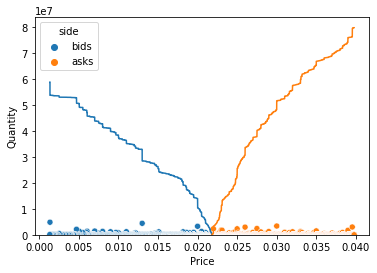

In [16]:
fig, ax = plt.subplots()

sns.ecdfplot(x='price', weights='quantity', stat='count', complementary=True, data=frames['bids'], ax=ax)
sns.ecdfplot(x='price', weights='quantity', stat='count', data=frames['asks'], ax=ax)
sns.scatterplot(x='price', y='quantity', hue='side', data=data, ax=ax)

ax.set_xlabel('Price')
ax.set_ylabel('Quantity')

plt.show()

## Smaller bid/ask split (no depth).

In [17]:
df = pd.DataFrame(client.get_ticker())
split = df[df['symbol'] == symbol][['bidQty', 'askQty']].iloc[0].astype(float)
#(((split.loc['askQty'] - split.loc['bidQty']) / split.loc['bidQty']) * 100)
split

bidQty      935.0
askQty    32874.0
Name: 2057, dtype: float64